## Setup

必要なライブラリをインポートして、初期化を行います。

Import the required libraries and initialize them:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped,PoseStamped
import tf2_ros
import sys

from utils import *
import cv2
import os


In [2]:
%%script bash --bg
rviz -d data/3_navigation.rviz > /dev/null 2>&1

Starting job # 0 in a separate thread.


In [2]:
##KNOWN LOCATIONS
kl_mess1= [1.04,0.3,90]
kl_table1= [1.04,1.3,90]
kl_tray=  [ -0.04168256822546347, 1.5,-90]
kl_box1=  [-0.04168256822546347, 2.427268271720426, -90]
### ARM 
arm_grasp_from_above=[0.19263830140116414,
 -2.2668981568652917,
 -0.007358947463759424,
 -0.9939144210462025,
 -0.17365421548386273,
 0.0]
arm_grasp_from_above_table=[0.41349380130577407,
 -1.671584191489468,
 -0.02774372779356371,
 -1.5952436225825641,
 0.22362492457833927,
 0.0]


arm_grasp_table=[0.41349380130577407,
 -1.671584191489468,
 -0.02774372779356371,
 0.0,
 0.22362492457833927,
 0.0]


arm_grasp_floor=[-1.5151551103007697e-05,
 -2.4,
 -0.2620865401925543,
 0.7019536624449207,
 0.20120924571306453,
 0.0]
arm_train_pose=[0.033749214744071214,
 -2.1204421063180217,
 -1.3982377978814715,
 -1.7296544561013807,
 2.135675364707808,
 0.0]

arm_ready_to_place=[0.03999320441056991,
 -0.4729690540086997,
 0.19361475012179108,
 -1.5269847787383313,
 -0.009753879176134461,
 0.0]

In [3]:
def segment_table2(chan):
    image_data=rgbd.get_image()
    points_data = rgbd.get_points()

    mask=np.zeros((image_data.shape))
    plane_mask=np.zeros((image_data.shape[0],image_data.shape[1]))

    plane_mask=image_data[:,:,chan]

    ret,thresh = cv2.threshold(image_data[:,:,2],240,255,200)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=image_data[:,:,0]
    _,contours, hierarchy = cv2.findContours(thresh.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        if area > 200 and area < 50000 :
            print('contour',i,'area',area)

            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            print boundRect
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            xyz=[]


            for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                    xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
            xyz=np.asarray(xyz)
            cent=xyz.mean(axis=0)
            cents.append(cent)
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
            cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
            print ('cX,cY',cX,cY)
    cents=np.asarray(cents)
    plt.imshow(img )
    return (cents)

In [4]:
def segment_table():
    image_data=rgbd.get_image()
    points_data = rgbd.get_points()

    mask=np.zeros((image_data.shape))
    plane_mask=np.zeros((image_data.shape[0],image_data.shape[1]))

    plane_mask=image_data[:,:,1]

    ret,thresh = cv2.threshold(image_data[:,:,2],240,255,200)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=image_data[:,:,0]
    _,contours, hierarchy = cv2.findContours(thresh.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        if area > 2000 and area < 50000 :
            print('contour',i,'area',area)

            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            print boundRect
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            xyz=[]


            for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                    xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
            xyz=np.asarray(xyz)
            cent=xyz.mean(axis=0)
            cents.append(cent)
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
            cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
            print ('cX,cY',cX,cY)
    cents=np.asarray(cents)
    plt.imshow(img )
    return (cents)

In [5]:
def segment_floor():
        image_data=rgbd.get_image()
        points_data = rgbd.get_points()

##### WILL PACKAGE IT BETTER SOON I PROMISE######################################################################
        ##px pixels /2D world  P1 3D world
        px_y,px_x=-1,-200
        P1= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
        px_y,px_x=-1,200
        P2= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
        px_y,px_x=-150,320
        P3= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
        #      

        V1 =P1 - P2
        V2= P3-P2
        nx,ny,nz=np.cross(V2,V1)
        print('look at the phi angle  in normal vector', np.rad2deg(cart2spher(nx,ny,nz))[2]-90)
        trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
        euler=tf.transformations.euler_from_quaternion(rot)
        print(   np.rad2deg(euler)[1],'if this degree is not the same as head tilt plane was not found')
        
        mask=np.zeros((image_data.shape))
        plane_mask=np.zeros((image_data.shape[0],image_data.shape[1]))
        mask[:,:,0]=points_data['x'] - P1[0]
        mask[:,:,1]=points_data['y'] - P1[1]
        mask[:,:,2]=points_data['z'] - P1[2]
        for i in range (image_data.shape[0]):
            for j in range (image_data.shape[1]):
                plane_mask[i,j]=-np.dot(np.asarray((nx,ny,nz,)),mask[i,j])
        plane_mask=plane_mask-np.min(plane_mask)
        plane_mask=plane_mask*256/np.max(plane_mask)
        plane_mask.astype('uint8')

        ret,thresh = cv2.threshold(plane_mask,3,255,0)

        cv2_img=plane_mask.astype('uint8')
        img=plane_mask.astype('uint8')
        _,contours, hierarchy = cv2.findContours(thresh.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        i=0
        cents=[]
        for i, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            
            if area > 200 and area < 50000 :
                #print('contour',i,'area',area)
                
                boundRect = cv2.boundingRect(contour)
                #just for drawing rect, dont waste too much time on this
                img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,0,0), 2)
                # calculate moments for each contour
                xyz=[]
                
                
                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                M = cv2.moments(contour)
                # calculate x,y coordinate of center
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        cents=np.asarray(cents)
        plt.imshow(img)
        return cents

In [6]:
def publish_scene():

    p = PoseStamped()
    p.header.frame_id ="map"# "head_rgbd_sensor_link"
    big_table_size = [1.7, 0.13, .7]
    p.pose.position.x = 0.95
    p.pose.position.y = 1.9
    p.pose.position.z = 0.34

    p.pose.orientation.x= 0.5*np.pi
    p.pose.orientation.w= 0.5*np.pi

    scene.add_box("table_big",p,big_table_size)

    p = PoseStamped()
    p.header.frame_id ="map"# "head_rgbd_sensor_link"
    table_small_size = [0.5, 0.01, .4]
    p.pose.position.x = .1
    p.pose.position.y = 1.9
    p.pose.position.z = 0.61
    p.pose.orientation.x= 0.5*np.pi
    p.pose.orientation.w= 0.5*np.pi

    scene.add_box("table_small",p,table_small_size)

    p = PoseStamped()
    p.header.frame_id ="map"# "head_rgbd_sensor_link"
    table_tray_size = [0.65, 0.01, .7]
    p.pose.position.x = 1.8
    p.pose.position.y = -0.65
    p.pose.position.z = 0.4
    p.pose.orientation.x= 0.5*np.pi
    p.pose.orientation.w= 0.5*np.pi
    scene.add_box("table_tray",p,table_tray_size)
    return True


In [7]:
#TF WRT HEAD SENSOR
def static_tf_publish(cents):
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'Closest_Object'+str(i),"head_rgbd_sensor_link")
        rospy.sleep(.2)
        xyz_map,cent_quat= listener.lookupTransform('/map', 'Closest_Object'+str(i),rospy.Time(0))
        map_euler=tf.transformations.euler_from_quaternion(cent_quat)
        rospy.sleep(.2)
        static_transformStamped = TransformStamped()

        ##FIXING TF TO MAP ( ODOM REALLY)    
        #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
        static_transformStamped.header.stamp = rospy.Time.now()
        static_transformStamped.header.frame_id = "map"
        static_transformStamped.child_frame_id = "static"+str(i)
        static_transformStamped.transform.translation.x = float(xyz_map[0])
        static_transformStamped.transform.translation.y = float(xyz_map[1])
        static_transformStamped.transform.translation.z = float(xyz_map[2])
        #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
        static_transformStamped.transform.rotation.x = 0#-quat[0]#trans.transform.rotation.x
        static_transformStamped.transform.rotation.y = 0#-quat[1]#trans.transform.rotation.y
        static_transformStamped.transform.rotation.z = 0#-quat[2]#trans.transform.rotation.z
        static_transformStamped.transform.rotation.w = 1#-quat[3]#trans.transform.rotation.w


        tf_static_broadcaster.sendTransform(static_transformStamped)
    return True
    


    


    
    

In [8]:
def cart2spher(x,y,z):
    ro= np.sqrt(x**2+y**2+z**2)
    th=np.arctan2(y,x)
    phi=np.arctan2((np.sqrt(x**2+y**2)),z)
    return np.asarray((ro,th,phi))
def spher2cart(ro,th,phi):
    x= ro * np.cos(th)* np.sin(phi)
    y= ro * np.sin(th)* np.sin(phi)
    z= ro*  np.cos(th)
    return np.asarray((x,y,z))

In [9]:

rospy.init_node("recognition")


In [14]:
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()
import moveit_commander
import moveit_msgs.msg
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0])

rvizを起動します．ロボットモデル、カメラ映像、ポイントクラウドが表示されています。

In [15]:
rgbd = RGBD()


In [16]:
scene = moveit_commander.PlanningSceneInterface()

In [17]:
scene_pub = rospy.Publisher('planning_scene',
                                         moveit_msgs.msg.PlanningScene,
                                         queue_size=5)

In [18]:
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
from geometry_msgs.msg import PoseStamped, Point , Quaternion
from actionlib_msgs.msg import GoalStatus

In [19]:
"""pose_tray_1

frame_id: "odom"
pose: 
  position: 
    x: 2.07474262655
    y: -0.463993086819
    z: 0.470428742931
  orientation: 
    x: 0.787825948964
    y: -0.583793844356
    z: 0.156526059701
    w: 0.118383335252"""

'pose_tray_1\n\nframe_id: "odom"\npose: \n  position: \n    x: 2.07474262655\n    y: -0.463993086819\n    z: 0.470428742931\n  orientation: \n    x: 0.787825948964\n    y: -0.583793844356\n    z: 0.156526059701\n    w: 0.118383335252'

<a id='start'></a>

In [ ]:
goal_x , goal_y,goal_yaw= kl_mess1# 1.04,0.3,1.57   #Known location mess 1
 

scene.remove_world_object()
#Takeshi neutral
move_hand(0)
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()
move_base_goal(goal_x,goal_y,goal_yaw)


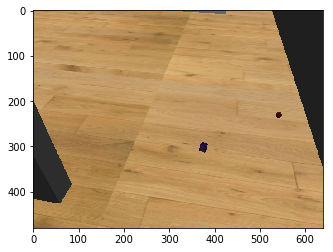

In [50]:
x=rgbd.get_image()
plt.imshow(x)

In [42]:
head.set_named_target('neutral')
head.go()
head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-40)
head.go(head_val)


True

In [48]:
def segment_floor():
        image_data=rgbd.get_image()
        points_data = rgbd.get_points()

##### WILL PACKAGE IT BETTER SOON I PROMISE######################################################################
        ##px pixels /2D world  P1 3D world
        px_y,px_x=-1,-200
        P1= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
        px_y,px_x=-1,200
        P2= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
        px_y,px_x=-150,320
        P3= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
        #      

        V1 =P1 - P2
        V2= P3-P2
        nx,ny,nz=np.cross(V2,V1)
        print('look at the phi angle  in normal vector', np.rad2deg(cart2spher(nx,ny,nz))[2]-90)
        trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
        euler=tf.transformations.euler_from_quaternion(rot)
        print(   np.rad2deg(euler)[1],'if this degree is not the same as head tilt plane was not found')
        
        mask=np.zeros((image_data.shape))
        plane_mask=np.zeros((image_data.shape[0],image_data.shape[1]))
        mask[:,:,0]=points_data['x'] - P1[0]
        mask[:,:,1]=points_data['y'] - P1[1]
        mask[:,:,2]=points_data['z'] - P1[2]
        for i in range (image_data.shape[0]):
            for j in range (image_data.shape[1]):
                plane_mask[i,j]=-np.dot(np.asarray((nx,ny,nz,)),mask[i,j])
        plane_mask=plane_mask-np.min(plane_mask)
        plane_mask=plane_mask*256/np.max(plane_mask)
        plane_mask.astype('uint8')

        ret,thresh = cv2.threshold(plane_mask,3,255,0)

        cv2_img=plane_mask.astype('uint8')
        img=plane_mask.astype('uint8')
        _,contours, hierarchy = cv2.findContours(thresh.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        i=0
        cents=[]
        for i, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            
            if area > 200 and area < 50000 :
                #print('contour',i,'area',area)
                
                boundRect = cv2.boundingRect(contour)
                #just for drawing rect, dont waste too much time on this
                img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,0,0), 2)
                # calculate moments for each contour
                xyz=[]
                
                
                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                M = cv2.moments(contour)
                # calculate x,y coordinate of center
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        cents=np.asarray(cents)
        plt.imshow(img)
        return cents

('look at the phi angle  in normal vector', -40.22940876043303)
(40.13507517924205, 'if this degree is not the same as head tilt plane was not found')


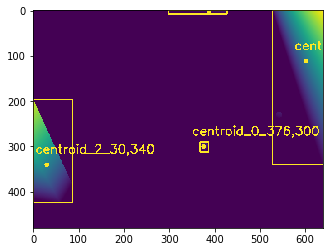

In [49]:
 cents=segment_floor()

In [ ]:
move_base_goal(goal_x,goal_y,goal_yaw)
head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)
head.go(head_val)

trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))

euler=tf.transformations.euler_from_quaternion(rot)

trans, euler
cents=segment_floor()
static_tf_publish(cents)

In [ ]:
publish_scene()
arm.go(arm_grasp_floor)
move_hand(1)

In [ ]:
 cents


In [ ]:
trans_cents=[]
for i,cent in enumerate(cents):
    trans_map,_= listener.lookupTransform('/map', 'static'+str(i),rospy.Time(0))
    trans_cents.append(trans_map)
        

np.linalg.norm(np.asarray(trans_cents)- trans , axis=1)
closest_cent=np.argmin(np.linalg.norm(np.asarray(trans_cents)- trans , axis=1))



In [ ]:
np.asarray(trans_cents).T[1]

In [ ]:
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static'+str(closest_cent),rospy.Time(0))
trans_hand,rot_hand

In [ ]:
wb=whole_body.get_current_joint_values()
wb[0]+=trans_hand[2]-.1
wb[1]+=trans_hand[1]
whole_body.go(wb)

In [ ]:
closest_cent

In [ ]:
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static'+str(closest_cent),rospy.Time(0))
trans_hand,rot_hand

In [ ]:
wb=whole_body.get_current_joint_values()
wb[0]+=trans_hand[2]-.05
wb[1]+=trans_hand[1]
whole_body.go(wb)

In [ ]:
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static'+str(closest_cent),rospy.Time(0))
trans_hand,rot_hand

In [ ]:
move_hand(0)
ungrasped=[-0.00047048998088961014,
 -0.03874743486886725,
 -0.04825256513113274,
 0.038463464485261056,
 -0.03874743486886725]
grasped=[0.12814103131904275,
 -0.30672794406396453,
 0.21972794406396456,
 0.13252877558892262,
 -0.30672794406396453]
a=gripper.get_current_joint_values()
if     np.linalg.norm(a-np.asarray(grasped))  >  (np.linalg.norm(a-np.asarray(ungrasped))):
    print ('grasp seems to have failed')
else:
    print('super primitive fgrasp detector points towards succesfull ')
    wb=whole_body.get_current_joint_values()
    wb[0]+=trans_hand[2]-.3
    
    whole_body.go(wb)
a


In [ ]:


#move_hand(0)
#Takeshi neutral
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()

In [ ]:
goal_x , goal_y,goal_yaw=  kl_tray  #1.84,0.0,-90  #Known location tray 1
move_base_goal(goal_x,goal_y,-90)
publish_scene()

In [ ]:
arm.set_joint_value_target(arm_ready_to_place)
arm.go()

wb=whole_body.get_current_joint_values()
wb[0]+=-0.45
wb[4]+=-.3
whole_body.set_joint_value_target(wb)
whole_body.go()


In [ ]:
move_hand(1)

wb=whole_body.get_current_joint_values()
wb[0]+=0.3

whole_body.set_joint_value_target(wb)
whole_body.go()


In [ ]:
#REPEAT AS LONG AS THERE ARE GRASPABLE OBJECTS


<a id='repeat'></a>


In [ ]:
scene.remove_world_object()
goal_x,goal_y,goal_yaw=kl_table1
move_hand(0)
#Takeshi neutral
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()
move_base_goal(goal_x+.4,goal_y,goal_yaw)  

In [ ]:
#moveit
#MOVE IT MUST BE RUNNING. DECLARE A HEAD POSE
head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)
#WATCH OUT FOR JOINTS LIMITS (exorcist joke)
#plan and execute target pose
head.set_joint_value_target(head_val)
head.go()
### GET TF (REFERENCE FRAME FOR XTION SENSOR )
trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))

euler=tf.transformations.euler_from_quaternion(rot)

trans, euler

In [ ]:
cents=segment_table2(0)


In [ ]:
static_tf_publish(cents)
cents

In [ ]:
trans_cents=[]
for i,cent in enumerate(cents):
    trans_map,_= listener.lookupTransform('/map', 'static'+str(i),rospy.Time(0))
    trans_cents.append(trans_map)
        

np.linalg.norm(np.asarray(trans_cents)- trans , axis=1)
closest_cent=np.argmin(np.linalg.norm(np.asarray(trans_cents)- trans , axis=1))

print(closest_cent)

In [ ]:
# 1.04,0.3,1.57   #Known location mess 1
kl_table2= [0 , 1.29,90] 
kl_table1= [1.04 , 1.29,90] 
goal_x , goal_y,goal_yaw= kl_table2

#Takeshi neutral
move_hand(0)
arm.set_named_target('go')
arm.go()
move_base_goal(goal_x ,goal_y,goal_yaw)
head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-35)

head.go(head_val)

In [ ]:
cents=segment_table2()
static_tf_publish(cents)

In [ ]:
wb=whole_body.get_current_joint_values()
wb[3]+=.2
whole_body.go(wb)


In [ ]:
publish_scene()
move_hand(1)

#arm.set_joint_value_target(arm_grasp_from_above)
#arm.set_joint_value_target(arm_grasp_floor)
arm.set_joint_value_target(arm_grasp_table)
arm.go()



In [ ]:
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static0',rospy.Time(0))
trans_hand,rot_hand

In [ ]:
wb=whole_body.get_current_joint_values()
wb[0]+=trans_hand[2]-.07
wb[1]+=trans_hand[1]
wb[3]+=trans_hand[0]+.1
whole_body.go(wb)

In [ ]:
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static0',rospy.Time(0))
trans_hand,rot_hand

In [ ]:
wb=whole_body.get_current_joint_values()
wb[0]+=trans_hand[2]-.07
wb[1]+=trans_hand[1]
wb[3]+=trans_hand[0]
whole_body.go(wb)

In [ ]:
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static0',rospy.Time(0))
trans_hand,rot_hand

In [ ]:
scene.remove_world_object()


In [ ]:
wb=whole_body.get_current_joint_values()
wb[0]+=trans_hand[2]-.07
wb[1]+=trans_hand[1]
wb[3]+=trans_hand[0]
whole_body.go(wb)

In [ ]:
move_hand(0)
ungrasped=[-0.00047048998088961014,
 -0.03874743486886725,
 -0.04825256513113274,
 0.038463464485261056,
 -0.03874743486886725]
grasped=[0.12814103131904275,
 -0.30672794406396453,
 0.21972794406396456,
 0.13252877558892262,
 -0.30672794406396453]
a=gripper.get_current_joint_values()
if     np.linalg.norm(a-np.asarray(grasped))  >  (np.linalg.norm(a-np.asarray(ungrasped))):
    print ('grasp seems to have failed')
else:
    print('assuming succesful grasp')
    wb=whole_body.get_current_joint_values()
    wb[0]+=-0.2
    wb[3]+=0.2
    whole_body.set_joint_value_target(wb)
    whole_body.go()


In [ ]:
publish_scene()


In [ ]:

#move_hand(0)
#Takeshi neutral
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()

In [ ]:
goal_x , goal_y,goal_yaw=  kl_box1  #1.84,0.0,-90  #Known location tray 1
move_base_goal(goal_x,goal_y,-90)
publish_scene()

In [ ]:
arm.set_joint_value_target(arm_ready_to_place)
arm.go()

wb=whole_body.get_current_joint_values()
wb[0]+=-0.6
wb[4]+=-.3
whole_body.set_joint_value_target(wb)
whole_body.go()


In [ ]:
move_hand(1)

wb=whole_body.get_current_joint_values()
wb[0]+=0.3

whole_body.set_joint_value_target(wb)
whole_body.go()


[START](#start)


[REPEAT](#repeat)

In [ ]:
###Run again the appropriate blocks to try to look for legos on the way


###CAn you navigate through?

### Can we pick em up?


#PLEASE TRY THINGS HERE


In [ ]:

wb=whole_body.get_current_joint_values()
wb[0]+=-0.2
wb[3]+=0.2
whole_body.set_joint_value_target(wb)
whole_body.go()

In [ ]:
"""
pose_goal=whole_body.get_current_pose()
pose_goal.pose.position.x = xyz_map[0]
pose_goal.pose.position.y = xyz_map[1]
pose_goal.pose.position.z = xyz_map[2]+.06#.0155
whole_body.set_pose_target(pose_goal)
whole_body.go()"""

In [ ]:
"""a=arm.get_current_pose()
a.pose.position.z=xyz_map[0]
a.pose.position.z=xyz_map[1]
a.pose.position.z=0.05
arm.set_pose_target(a)
succ=arm.go()
succ"""

In [ ]:

move_hand(0)
#Takeshi neutral
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()

In [ ]:
### rubbish from here on.... 


In [ ]:
whole_body.set_joint_value_target(p)
whole_body.go()

In [ ]:
pose_goal=whole_body.get_current_pose()
pose_goal

In [ ]:
move_hand(1)

In [ ]:
whole_body.clear_pose_targets()
pose_goal=whole_body.get_current_pose()
pose_goal.pose.position.x = xyz_map[0]
pose_goal.pose.position.y = xyz_map[1]
pose_goal.pose.position.z = xyz_map[2]+.16
whole_body.set_pose_target(pose_goal)
whole_body.set_goal_tolerance(.001)
whole_body.allow_looking(True)

whole_body.go()
    

In [ ]:
for i in range(15):
    whole_body.set_pose_target(pose_goal)
    whole_body.go()

In [ ]:
move_hand(0)

In [ ]:
for i in range(5):
    #whole_body.set_pose_target(pose_goal)
    whole_body.go()

In [ ]:

move_hand(0)
#Takeshi neutral
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()

In [ ]:


#Takeshi neutral
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()

In [ ]:

arm.set_joint_value_target(arm_grasp_floor)
arm.go()

In [ ]:

arm.set_joint_value_target(arm_train_pose)


In [ ]:
arm.go()

In [ ]:
a=arm.get_current_joint_values()
a[0]=-.3
#a[-3]=-0.5*np.pi
#arm.set_joint_value_target(a)
#arm.go()


In [ ]:
move_hand(1)


In [ ]:
a=arm.get_current_joint_values()

a[0]+=.1

arm.set_joint_value_target(a)
arm.go()

In [ ]:

arm.set_joint_value_target(a)
arm.go()
#move_hand(0)


In [ ]:
a=arm.get_current_pose()
euler=tf.transformations.euler_from_quaternion((a.pose.orientation.x,a.pose.orientation.y,a.pose.orientation.z,a.pose.orientation.w))
euler

In [ ]:
#MOVE IT MUST BE RUNNING. DECLARE A HEAD POSE
head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)
#WATCH OUT FOR JOINTS LIMITS (exorcist joke)
#plan and execute target pose
head.set_joint_value_target(head_val)
head.go()

In [ ]:
whole_body.get_current_joint_values()[:3] 

In [ ]:
whole_body.get_active_joints()

In [ ]:

np.isclose(np.abs(cart2spher(nx,ny,nz))[2]-90 , 1.05   ,.1)

In [ ]:
np.isclose(np.abs(np.rad2deg(cart2spher(nx,ny,nz))[2]-90),np.abs(np.rad2deg(euler)[1]),1)

In [ ]:
scene.remove_world_object()

In [ ]:
rot


In [ ]:
tf.transformations.quaternion_from_euler(0,np.pi*.5,0)

In [ ]:
gripper.get_active_joints()

In [16]:
cuv=gripper.get_current_joint_values()

[0.04864392144339025,
 -0.10001174078352928,
 0.01301174078352929,
 0.09013803031711731,
 -0.10001174078352928]

In [ ]:
gripper.get_current_joint_values()


In [ ]:
gripper.allow_replanning()

In [ ]:
cents

In [ ]:
gripper.get_current_joint_values()

In [ ]:
gripper.clear_pose_targets()


In [ ]:
gripper.get_current_pose()

In [14]:
a=gripper.get_current_joint_values()
if     np.linalg.norm(a-np.asarray(grasped))  >  (np.linalg.norm(a-np.asarray(ungrasped))):
    print ('grasp seems to have failed')

NameError: name 'grasped' is not defined

In [25]:

ungrasped=[-0.00047048998088961014,
 -0.03874743486886725,
 -0.04825256513113274,
 0.038463464485261056,
 -0.03874743486886725]
"""grasped=[0.12814103131904275,
 -0.30672794406396453,
 0.21972794406396456,
 0.13252877558892262,
 -0.30672794406396453]
"""
grasped=[0.0432034, -0.1143983,  0.0273983,  0.0940839, -0.1143983]
a=gripper.get_current_joint_values()
if     np.linalg.norm(a-np.asarray(grasped))  >  (np.linalg.norm(a-np.asarray(ungrasped))):
    print ('grasp seems to have failed')
else:
    print('super primitive fgrasp detector points towards succesfull ')


super primitive fgrasp detector points towards succesfull 


In [24]:
cuv=np.asarray(gripper.get_current_joint_values())
cuv


array([ 0.0432034, -0.1143983,  0.0273983,  0.0940839, -0.1143983])

In [20]:
cuv-grasped

array([-0.080051  ,  0.19618064, -0.19618064, -0.03978544,  0.19618064])

In [21]:
gripper.get_active_joints()

['hand_l_spring_proximal_joint',
 'hand_motor_joint',
 'hand_r_spring_proximal_joint']

In [22]:
move_hand(0)

True